## Imports

In [214]:
import numpy as np
import matplotlib.pyplot as plt

from Modules.muon import Muon
from Modules.positron import Positron
import Modules.functions as func

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

## Setting up muons with all attributes

Generate "N" muons and create/store attributes dependent on lifetime, field strength, and field direction

In [215]:
N = 10000
field_strength = 0.001
particles = [Muon() for _ in range(N)]

for p in particles:
    p.total_rads = p.get_decay_orientation(field_strength)  # Total radians rotated in lifetime
    p.phase = np.random.uniform(0, 0)  # Add random starting phase to muons (Change to 2*np.pi)
    p.total_rads += p.phase  # Adding phase shift
    p.polarisation = p.get_spin_polarisation(field_strength, np.pi/2)  # 
    p.asym = func.count_asym(1/3, func.larmor_freq(field_strength), p.lifetime)

# Sorting particles list by lifetime
particles.sort(key=lambda x: x.lifetime)

# Storing values in arrays
times = list(map(lambda p: p.lifetime, particles))
asym = list(map(lambda p: p.asym, particles))
polar = list(map(lambda p: p.polarisation, particles))
# Take the modulus w.r.t 2pi so that value is {0, 2pi}. makes 2*n*pi == 2*pi
rads = list(map(lambda p: p.total_rads%(2*np.pi), particles))
polar_asym = [x*y for x, y in zip(polar, asym)]

#### Asymmetry
$A = a_0 \cos{(\omega \tau)}$

#### Polarisation
$\cos(\theta)^2 +  \sin(\theta)^2 \cos(\omega \tau)$

#### Decay orientation
Larmor frequency times lifetime of muon

#### Lifetime
Take the inverse of the decay function
$\lambda~e^{-\lambda \tau} \rightarrow \dfrac{-ln(U)}{\lambda}$<br>
Where U is a random number in range {0, 1}<br>
This returns a lifetime proportional to the exponetnial decay of muons.<br>
A histogram plot of the lifetimes confirms this works.


## Plotting asymmetry, polarisation and product

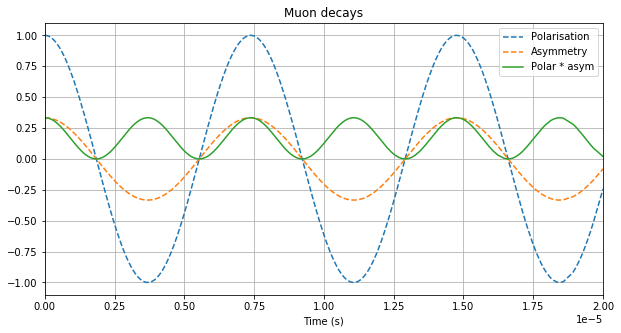

In [216]:
plt.figure()
plt.plot(times, polar, "--", label="Polarisation")
plt.plot(times, asym, "--", label="Asymmetry")
plt.plot(times, polar_asym, label="Polar * asym")

#temp = [i*2*np.pi for i in polar_asym]
#plt.plot(times, np.sin(temp), label="arcsin")

# FORMATTING
plt.xlabel("Time (s)")
plt.title("Muon decays")
plt.legend(loc="best")
plt.xlim(0, 20e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

## Asymmetry plot

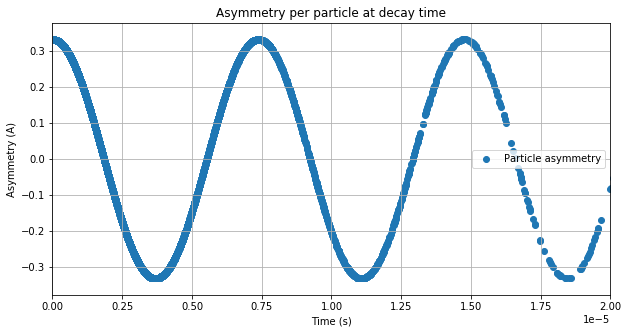

In [217]:
# PLOTTING
plt.figure()
plt.scatter(times, asym, label="Particle asymmetry")

# PLOT LABELS
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Asymmetry per particle at decay time")
plt.legend(loc="best")

# FORMATTING
plt.xlim(0, 20e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

## Plot of angle against decay time
Decay angle is a value [0, 2pi] for muons depending on larmor frequency and lifetime.

Attempting to recreate this image
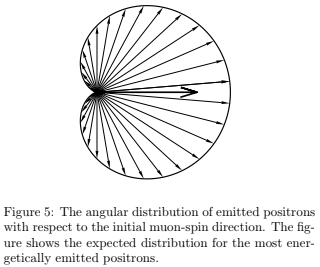

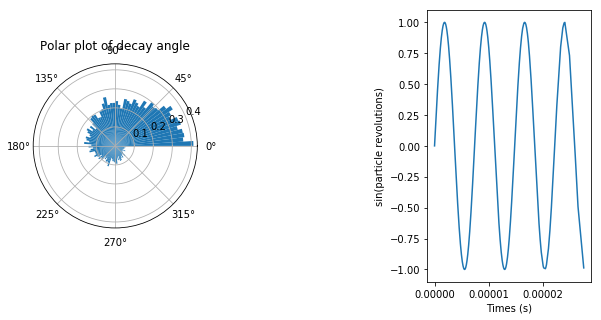

In [218]:
fig = plt.figure()
ax = fig.add_subplot(131, projection='polar')
ax.hist(rads, bins=100, density=True, histtype="bar")
ax.set_title("Polar plot of decay angle")
plt.rcParams["figure.figsize"] = (10,5)

ax2 = fig.add_subplot(133)
ax2.plot(times, np.sin(rads))
ax2.set_xlabel("Times (s)")
ax2.set_ylabel("sin(particle revolutions)")
plt.show()

## Histogram of decay times
Demonstrating the exponential decay of lifetimes for the muons and attempting to fit and the subtract the exponential to be left with continuous moun decay

In [219]:
# Used for curve_fitting the exponential term
def expon(x, A, k):
    return A*np.exp(x*k)

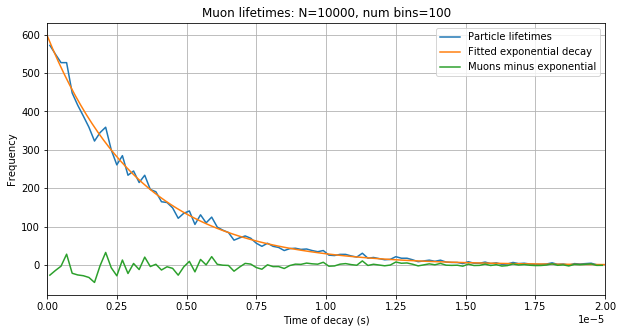

In [220]:
hist_points = int(N/100)
freq, bins, _ = plt.hist(times, bins=hist_points, density=False, range=(0, 20e-6))
plt.clf()
bins = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

time_array = np.linspace(0, 20e-6, hist_points)
popt, cpov = curve_fit(expon, bins, freq, p0=[100, -100])
fitted_freq = expon(time_array, *popt)

# Plotting
plt.plot(bins, freq, label="Particle lifetimes")
plt.plot(time_array, fitted_freq, label="Fitted exponential decay")
plt.plot(bins, (freq-fitted_freq), label="Muons minus exponential")

# Formatting
plt.xlabel("Time of decay (s)")
plt.ylabel("Frequency")
plt.xlim(0, 20e-6)
plt.legend(loc="best")
plt.title(f"Muon lifetimes: N={N}, num bins={hist_points}")
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.grid()
plt.show()

## Attempting to retrieve the Kubo-Toyabe function from the generated muons

In [221]:
def get_spin_relaxation(field, time, gyro):
    return (1/3) + ((2/3)*(np.cos(gyro * time * field)))

def gaussian_field(width, field):
    term1 = (Muon().gyro_ratio) / (((2*np.pi)**0.5) * width)
    term2 = np.exp( ((-Muon().gyro_ratio)**2) * (field**2) / (2*(width**2)))
    return term1 * term2

def get_kubo_toyabe_factor(parameter, t):
    return (1/3) + ( (2/3) * (1-((parameter**2) * (t**2))) * np.exp(-0.5*(parameter**2)*(t**2)) ) 

Plotting the relaxation in magnetic fields with no distribution (all fields assumed to lie exactly on axis)

In [222]:
fields = [0.0001, 0.00015, 0.0002, 0.00025, 0.0003]  # Field strength in Tesla
widths = [1e4, 5e4, 1e5]  # Width of random fields
times =  np.linspace(0, 200e-6, N)

angles = np.zeros([5, N])
angle_average = np.zeros(N)

# Creating data for different field strengths
for i, strength in enumerate(fields):
    for j, t in enumerate(times):
        angles[i][j] = get_spin_relaxation(strength, t, Muon.gyro_ratio)

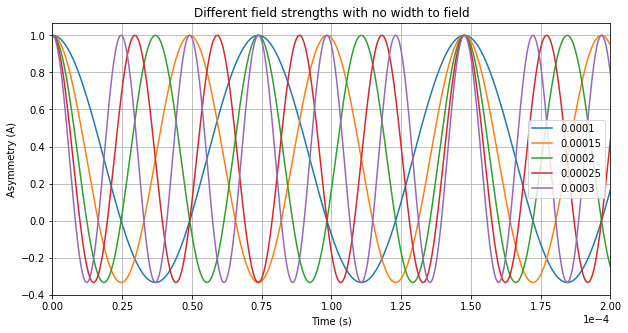

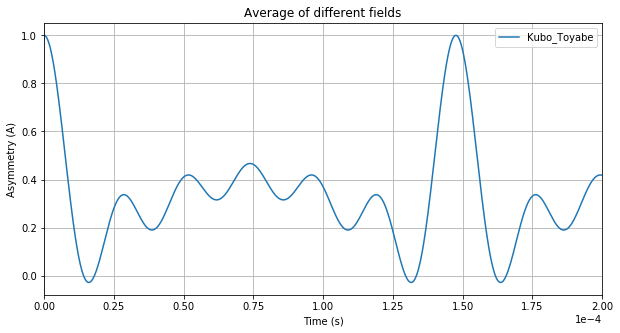

In [223]:
# Plotting field strength graphs
plt.figure()
for i in range(5):
    plt.plot(times, angles[i], label="{}".format(fields[i]))
    angle_average = np.add(angles[i], angle_average)
plt.legend(loc="best")
plt.xlim(0, 200e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Different field strengths with no width to field")
plt.show()

# Plotting average graph
plt.figure()
angle_average = [i/5 for i in angle_average]
plt.plot(times, angle_average, label="Kubo_Toyabe")

plt.legend(loc="best")
plt.xlim(0, 200e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Average of different fields")
plt.show()

#### KUBO-TOYABE FUNCTION
Adding random widths in range {1e4, 1e5} and averaging the results recovers the kubo-toyabe function

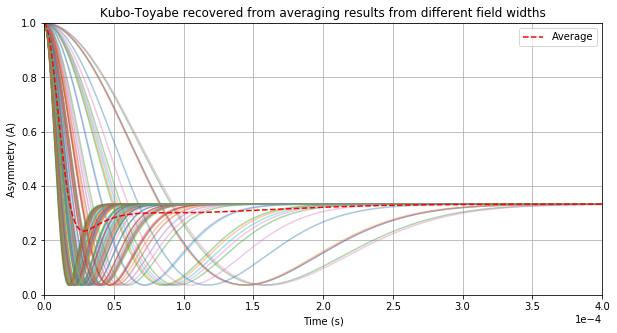

In [224]:
# Initiallising variables
fields = [0.001, 0.0015, 0.002, 0.0025, 0.003]
widths = np.random.uniform(1e4, 1e5, 100)
#widths = np.linspace(1e4, 1e5, 10)
times =  np.linspace(0, 400e-6, N)

polar_av = np.zeros(N)
polarisation = np.zeros([len(widths), N])

for i, w in enumerate(widths):
    for j, t in enumerate(times):
        polarisation[i][j] = get_kubo_toyabe_factor(w, t)
    polar_av = np.add(polar_av, polarisation[i]/len(widths))
        
# Plotting
plt.figure()
for increment, param in enumerate(widths):
    plt.plot(times, polarisation[increment,:], alpha=0.4)
    
plt.plot(times, polar_av, "--r", label="Average")
# Plot formatting
plt.legend(loc="best")
plt.xlim(0, 400e-6)
plt.ylim(0, 1)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
#plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Kubo-Toyabe recovered from averaging results from different field widths")
plt.show()